## ML Supervisado: Regresiones - Tarea Individual

### Entrega 13/11 a correo marcelo.medel.v@gmail.com.

- (30%) Pregunta 1:
    - ¿Qué entiende del método de ajuste por mínimos cuadrados ordinarios (OLS)? Investigue y desarrolle.

- (10%) Pregunta 2:
    - ¿En qué casos puede ser útil medir el **MAPE** como métrica de error? En el código se le entrega el método para calcular la métrica.

- (60%) Pregunta 3:

    - Utilice los mismos datos y códigos del ejemplo a continuación, pero utilizando lo siguiente:
        * **X**: *Global_reactive_power, Voltage, Sub_metering_1, Sub_metering_2, Sub_metering_3*
        * **Y**: *Global Intensity*

    - **Preguntas**:

        * ¿Existen valores anormales en los datos (outliers)? ¿será necesario hacer algún tipo de tratamiento a estos datos?.
        * ¿Será necesario escalar los datos?, en caso de utilizar algún método de escalamiento (MinMax, Standard, Robust, otro), ¿mejora o empeora los resultados de los modelos?.
        * ¿Para qué sirve la métrica *explained variance*? El cálculo se encuentra en el código.
        * ¿Qué hiperparámetros de los modelos modificó para llegar a la mejor solución?
        * De los modelos que desarrolló ¿cuál es el que tiene mejor performance respecto a las métricas? interprete los resultados basándose en las métricas.
        * ¿Qué diferencias observa al mirar los coeficientes de cada modelo? Interprete cuales son las variables que mejor modelan el problema.



## Regression Example 

* Instale la última versión disponible de scikit learn. Para este ejemplo es necesaria la versión 1.0 para poder desarrollar la métrica RMSE.

* El ejercicio fue tomado de Kaggle: https://www.kaggle.com/akouaorsot/power-consumption-regression-rmse-0-04

### Explicación tomada de Kaggle.

#### Context

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

**Data Set Characteristics**:
Multivariate, Time-Series

**Associated Tasks**:
Regression, Clustering

Data Set Information:

This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

#### Notes:
1.**Power Consumption** : (globalactivepower *1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.

2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

**Attribute Information**:
1.**date**: Date in format dd/mm/yyyy

2.**time**: time in format hh:mm:ss

3.**globalactivepower**: household global minute-averaged active power (in kilowatt)

4.**globalreactivepower**: household global minute-averaged reactive power (in kilowatt)

5.**voltage**: minute-averaged voltage (in volt)

6.**global_intensity**: household global minute-averaged current intensity (in ampere)

7.**submetering1**: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.**submetering2**: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.**submetering3**: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [1]:
import sklearn
print(sklearn.__version__)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1.5.2


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (12,8)})


## Data Preprocessing

* Cargamos los datos
* Se reemplazan valores nulos o incorrectos con valor -1
* Se realiza cambio de tipo de datos para las variables numéricas
* Se realiza una imputación de los valores -1 por la media de los valores
* Se crea el atributo *power_consumption* a partir de la fórmula descrita anteriormente

In [3]:
%%time
url = 'https://drive.google.com/file/d/1OSVHFfu0otaLWzd59i0Mo3iGzgpCCqt-/view?usp=drive_link'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
#df = pd.read_csv('../data/household_power_consumption.txt',sep=";")
df = pd.read_csv(path, sep=";", encoding="ISO-8859-1", header=0, compression='zip')
df.head()

CPU times: user 2 s, sys: 307 ms, total: 2.31 s
Wall time: 13.7 s


<timed exec>:4: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [5]:
# Feature Modification
from sklearn.impute import SimpleImputer

df['Date'] = df['Date'].astype(str)
df['Time'] = df['Time'].astype(str)
df.replace(['?', 'nan', np.nan], -1, inplace=True) 
num_vars= ['Global_active_power', 'Global_reactive_power', 'Voltage', 
           'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for i in num_vars:
    df[i] = pd.to_numeric(df[i])
imp = SimpleImputer(missing_values=-1, strategy='mean')
df[num_vars] = imp.fit_transform(df[num_vars])

# Target Variable
df['power_consumption'] = (df['Global_active_power']*1000/60) - (df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3'])

df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,power_consumption
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


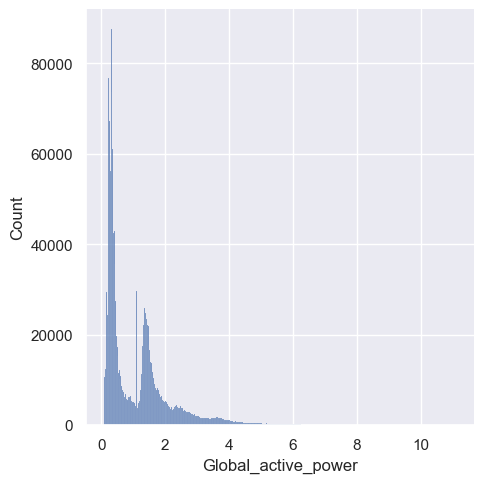

CPU times: user 1 s, sys: 65.3 ms, total: 1.07 s
Wall time: 1.11 s


In [6]:
%%time
# Distribution of the target variables
sns.displot(data=df, x='Global_active_power')
plt.show()

<timed exec>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<timed exec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


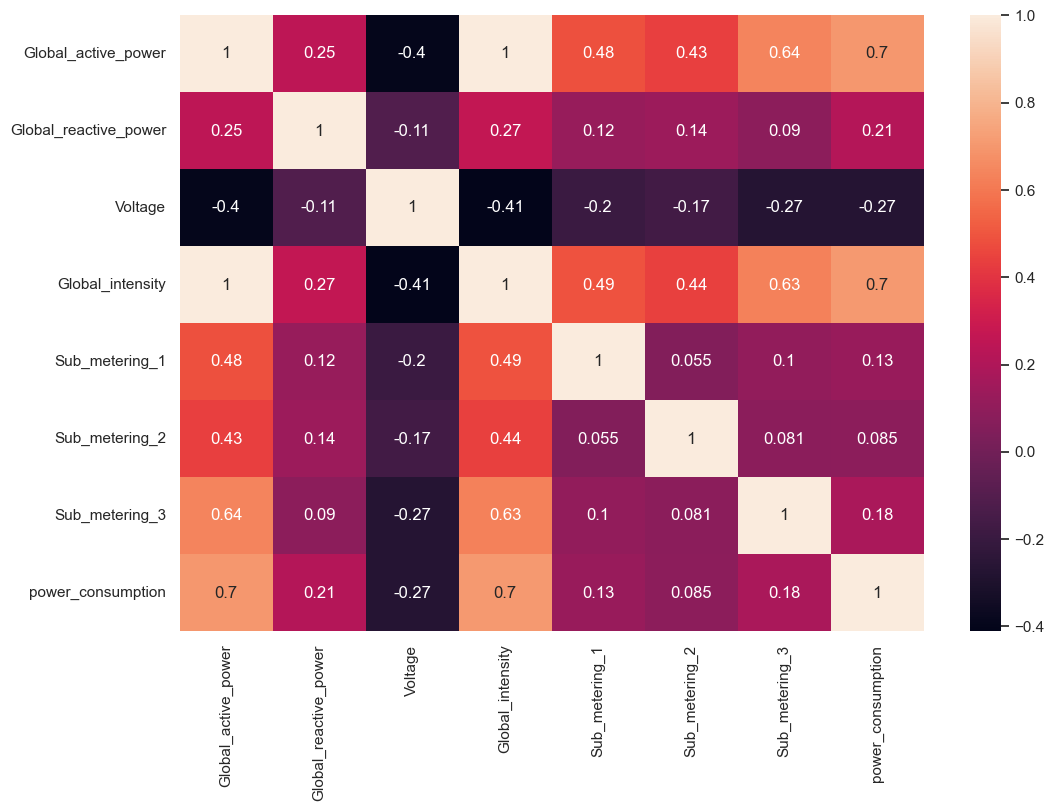

CPU times: user 749 ms, sys: 15.5 ms, total: 765 ms
Wall time: 839 ms


In [7]:
%%time
corr = np.corrcoef(df.corr())
sns.heatmap(df.corr(), annot=True)
plt.show()

### Train / test split process

* Para poder entrenar el modelo se dividen los datos en entrenamiento (70%) y test (30%).
* Se definen las variables independientes (**X**): *Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, Sub_metering_3*
* Se define la variable dependiente (**Y**): *Global_active_power*.

In [8]:
from sklearn.model_selection import train_test_split

cols = ['Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
X = df[cols].values
Y = df['Global_active_power'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 13)

### Métricas
* Para medir la performance de nuestro modelo utilizaremos las siguientes métricas:
    * Mean Absolute Error (**MAE**)
    * Mean Squared Error (**RMSE**)
    * Root Mean Squared Error: (**RMSE**)
    * R2
    * Explained variance

In [9]:
### Metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,explained_variance_score, mean_absolute_percentage_error, root_mean_squared_error

def get_metrics(Y_test,pred):
    mae = round(mean_absolute_error(Y_test,pred),3)
    mse = round(mean_squared_error(Y_test, pred), 3)
    rmse = round(root_mean_squared_error(Y_test, pred), 3)
    mape = round(mean_absolute_percentage_error(Y_test, pred), 3)
    r2 = round(r2_score(Y_test,pred), 4)
    ev = round(explained_variance_score(Y_test,pred), 4)
    return {'mae':mae,'mse':mse,'rmse':rmse, 'mape':mape,'r2':r2,'ev':ev}

### Modelos

Se desarrollan los modelos de regresión lineal, regularización de Ridge, regularización de Lasso, Elastic Net y Decision Tree.

Adicionalmente se desarrollan los modelos con Cross Validation para Elastic Net, Ridge y Lasso.

In [10]:
### variables para guardar información relevante de los modelos
models = {}
coefs = {}

#### Linear Regression

In [11]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X_train,Y_train)
pred = reg_model.predict(X_test)
models['linear'] = get_metrics(Y_test,pred)
coefs['linear'] = reg_model.coef_

CPU times: user 281 ms, sys: 76.2 ms, total: 357 ms
Wall time: 148 ms


#### Ridge Regression

In [12]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
from sklearn.linear_model import Ridge

alpha = 0.5
ridge_model = Ridge(alpha=alpha, random_state=13)
ridge_model.fit(X_train,Y_train)
pred = ridge_model.predict(X_test)
models['ridge'] = get_metrics(Y_test,pred)
coefs['ridge'] = ridge_model.coef_

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
CPU times: user 168 ms, sys: 51.4 ms, total: 219 ms
Wall time: 141 ms


#### Ridge Cross Validation

In [13]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV
from sklearn.linear_model import RidgeCV

alphas = [0.1, 0.5, 0.8]
ridgeCV_model = RidgeCV(alphas=alphas)
ridgeCV_model.fit(X_train,Y_train)
pred = ridgeCV_model.predict(X_test)
models['ridgeCV'] = get_metrics(Y_test,pred)
coefs['ridgeCV'] = ridgeCV_model.coef_

CPU times: user 800 ms, sys: 220 ms, total: 1.02 s
Wall time: 275 ms


#### Lasso Regression

In [14]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.linear_model import Lasso

alpha = 0.5
lasso_model = Lasso(alpha=alpha, random_state=13)
lasso_model.fit(X_train, Y_train)
pred = lasso_model.predict(X_test)
models['lasso'] = get_metrics(Y_test,pred)
coefs['lasso'] = lasso_model.coef_

CPU times: user 227 ms, sys: 42.1 ms, total: 269 ms
Wall time: 71.4 ms


#### Lasso Cross Validation 

In [15]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
from sklearn.linear_model import LassoCV

alphas = [0.1, 0.5, 0.8]
lassoCV_model = LassoCV(alphas=alphas, random_state=13)
lassoCV_model.fit(X_train, Y_train)
pred = lassoCV_model.predict(X_test)
models['lassoCV'] = get_metrics(Y_test,pred)
coefs['lassoCV'] = lassoCV_model.coef_

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Ridge vs Lasso

* Lasso consigue seleccionar predictores, es decir convierte a cero la importancia de un feature, en cambio Ridge considera todo, dando menos peso a los menos importantes.
* Lasso tiene ventaja en escenarios donde no todos los predictores son importantes para el modelo y se desea que los **menos influyentes queden excluidos**.
* Por otro lado, **cuando existen predictores altamente correlacionados linealmente, Ridge reduce la influencia de todos ellos a la vez y de forma proporcional**, **mientras que Lasso tiende a seleccionar uno de ellos, dándole todo el peso y excluyendo al resto.** En presencia de correlaciones, esta selección varía mucho con pequeñas perturbaciones (cambios en los datos de entrenamiento), por lo que, las soluciones de Lasso son muy inestables si los predictores están altamente correlacionados.
* Para conseguir un equilibrio óptimo entre estas dos propiedades, se puede emplear lo que se conoce como penalización Elastic Net, que combina ambas estrategias.

#### Elastic Net

In [16]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html?highlight=elastic%20net#sklearn.linear_model.ElasticNet
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(random_state=13)
elastic_model.fit(X_train, Y_train)
pred = elastic_model.predict(X_test)
models['elastic'] = get_metrics(Y_test,pred)
coefs['elastic'] = elastic_model.coef_

CPU times: user 192 ms, sys: 34.3 ms, total: 226 ms
Wall time: 54.7 ms


#### Elastic Net CV

In [17]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
from sklearn.linear_model import ElasticNetCV

elasticCV_model = ElasticNetCV(random_state=13)
elasticCV_model.fit(X_train, Y_train)
pred = elasticCV_model.predict(X_test)
models['elasticCV'] = get_metrics(Y_test,pred)
coefs['elasticCV'] = elasticCV_model.coef_

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### Decision Tree

In [18]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(random_state=0)
tree_model = tree_model.fit(X_train, Y_train)
pred = tree_model.predict(X_test)
models['decision_tree'] = get_metrics(Y_test,pred)

CPU times: user 4.87 s, sys: 116 ms, total: 4.99 s
Wall time: 6.91 s


### Verificación de resultados de los modelos

In [19]:
df_coef = pd.DataFrame.from_dict(coefs,orient='index',columns=cols).reset_index()
df_metrics = pd.DataFrame.from_dict(models)

In [20]:
df_metrics

,linear,ridge,ridgeCV,lasso,lassoCV,elastic,elasticCV,decision_tree
mae,0.0260,0.0260,0.0260,0.0900,0.0350,0.1030,0.0300,0.0220
mse,0.0020,0.0020,0.0020,0.0150,0.0030,0.0220,0.0020,0.0020
rmse,0.0400,0.0400,0.0400,0.1240,0.0520,0.1470,0.0450,0.0420
mape,0.0460,0.0460,0.0460,0.1740,0.0580,0.1990,0.0540,0.0370
r2,0.9985,0.9985,0.9985,0.9862,0.9976,0.9804,0.9982,0.9984
ev,0.9985,0.9985,0.9985,0.9862,0.9976,0.9804,0.9982,0.9984


In [21]:
df_coef

,index,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,linear,-0.175137,0.004443,0.238028,-0.000320,-0.000448,0.002177
1,ridge,-0.175132,0.004443,0.238028,-0.000320,-0.000448,0.002177
2,ridgeCV,-0.175136,0.004442,0.238029,-0.000319,-0.000447,0.002178
3,lasso,0.000000,-0.000000,0.206192,0.000000,0.000000,0.004857
4,lassoCV,-0.000000,0.000000,0.228853,0.000000,0.000000,0.003067
5,elastic,0.000000,-0.000000,0.197930,0.000000,0.000000,0.007530
6,elasticCV,-0.000000,0.003571,0.235132,0.000000,-0.000000,0.002705
